# ARC-AGI 2025: Training Notebook

This notebook trains a baseline sequence-to-sequence Transformer on the generated ARC-AGI dataset (`artifacts/datasets/*.jsonl`).

Sections:
1. Setup
2. Dependencies
3. Device & Determinism
4. Load Dataset
5. Visualize Samples
6. Tokenization & Augmentations
7. Datasets & DataLoaders
8. Transformer Model
9. Loss/Optimizer/Scheduler
10. Training Loop
11. Validation Metrics
12. Inference Solver
13. Save Artifacts
14. Unit Tests
15. Hyperparameter Sweep (optional)
16. Export to TorchScript/ONNX (optional)

In [19]:
from __future__ import annotations
import os, json, time, random
from pathlib import Path
CWD = Path.cwd()
CANDIDATES = [CWD, *CWD.parents]
PROJECT_ROOT = None
for p in CANDIDATES:
    if (p / 'artifacts').exists() and (p / 'models').exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    PROJECT_ROOT = CWD if (CWD / 'artifacts').exists() else CWD.parent
DATASETS_DIR = PROJECT_ROOT / 'artifacts' / 'datasets'
MODELS_DIR = PROJECT_ROOT / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
run_id = time.strftime('%Y%m%d-%H%M%S')
RUN_DIR = MODELS_DIR / f'run_{run_id}'
RUN_DIR.mkdir(parents=True, exist_ok=True)
print('Project root:', PROJECT_ROOT)
print('Datasets dir:', DATASETS_DIR)
print('Run dir:', RUN_DIR)

Project root: c:\Users\aibel\OneDrive\Documents\Code\arc-agi
Datasets dir: c:\Users\aibel\OneDrive\Documents\Code\arc-agi\artifacts\datasets
Run dir: c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414


In [20]:
import sys
try:
    import torch
except Exception:
    %pip install torch --quiet
    import torch
try:
    import einops
except Exception:
    %pip install einops --quiet
    import einops
try:
    import tqdm
except Exception:
    %pip install tqdm --quiet
    import tqdm
try:
    import matplotlib
except Exception:
    %pip install matplotlib --quiet
    import matplotlib
from typing import List, Tuple, Dict, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
print('Python', sys.version)
print('Torch', torch.__version__)
print('NumPy', np.__version__)

Python 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Torch 2.8.0+cpu
NumPy 2.3.2


In [21]:
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    try:
        torch.set_float32_matmul_precision('high')
    except Exception:
        pass
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [22]:
from dataclasses import dataclass
@dataclass
class Sample:
    split: str
    task_id: str
    subset: str
    index: int
    input: List[List[int]]
    output: List[List[int]]
    transform: dict

def read_jsonl(path: Path):
    with path.open('r') as f:
        for line in f:
            if line.strip():
                yield json.loads(line)

def load_split(name: str):
    path = DATASETS_DIR / f'{name}.jsonl'
    if not path.exists():
        print(f'Warning: dataset not found: {path}')
        return []
    data = []
    for rec in read_jsonl(path):
        if 'input' in rec and 'output' in rec:
            data.append(Sample(
                split=rec['split'], task_id=rec['task_id'], subset=rec['subset'], index=rec['index'],
                input=rec['input'], output=rec['output'], transform=rec.get('transform', {})
            ))
    return data
train_samples = load_split('training')
val_samples = load_split('evaluation')
if not val_samples and len(train_samples) > 10:
    n = int(0.9 * len(train_samples))
    val_samples = train_samples[n:]
    train_samples = train_samples[:n]
print(f'Train samples: {len(train_samples)} | Val samples: {len(val_samples)}')

Train samples: 3232 | Val samples: 358


In [23]:
# === Small Experiment Subset Setup ===
# Reduce dataset size for a fast baseline experiment run.
MAX_TRAIN = 200           # cap number of training examples considered (set None for full)
VAL_RATIO = 0.1           # portion of (post-cap) training examples to use as validation if evaluation split empty
FORCE_RESPLIT = True      # force re-splitting even if evaluation examples exist (set False to keep evaluation split)

original_train_len = len(train_samples)
original_val_len = len(val_samples)

# Cap train set
if MAX_TRAIN is not None and len(train_samples) > MAX_TRAIN:
    train_samples = train_samples[:MAX_TRAIN]

# Re-split if evaluation empty or forced
if FORCE_RESPLIT or (not val_samples):
    cut = int(len(train_samples) * (1 - VAL_RATIO))
    if cut <= 0: cut = max(1, len(train_samples) - 1)
    val_samples = train_samples[cut:]
    train_samples = train_samples[:cut]

print(f"Small experiment: train={len(train_samples)} val={len(val_samples)} (orig train={original_train_len} val={original_val_len})")

Small experiment: train=180 val=20 (orig train=3232 val=358)


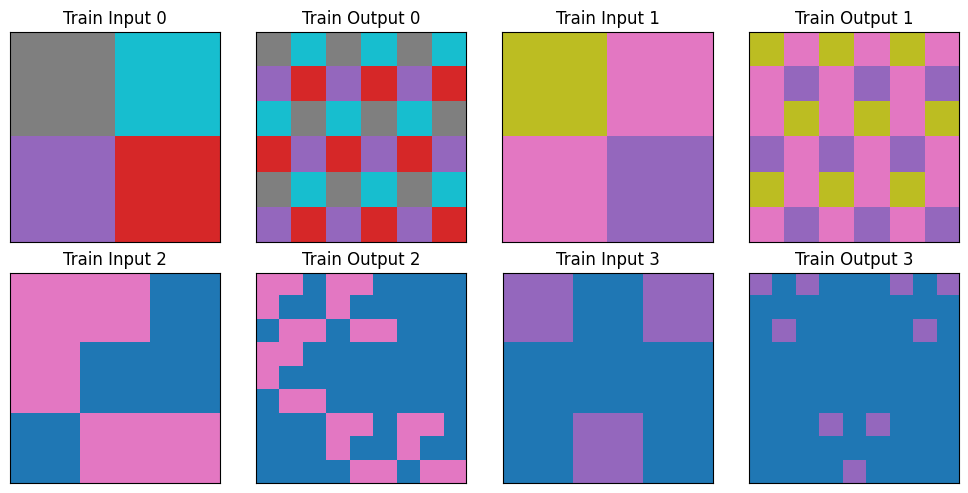

In [24]:
from itertools import islice
def show_grid(ax, grid, title=""):
    arr = np.array(grid, dtype=int)
    cmap = plt.get_cmap('tab10', 10)
    ax.imshow(arr, cmap=cmap, vmin=0, vmax=9)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
fig, axes = plt.subplots(2, 4, figsize=(10,5))
axes = axes.ravel()
for i, s in enumerate(islice(train_samples, 4)):
    show_grid(axes[2*i], s.input, f"Train Input {i}")
    show_grid(axes[2*i+1], s.output, f"Train Output {i}")
plt.tight_layout()
plt.show()

In [25]:
PAD, BOS, EOS, SEP = 10, 11, 12, 13
VOCAB_SIZE = 14

def normalize_grid(grid: List[List[int]] | List[int] | int) -> np.ndarray:
    arr = np.array(grid, dtype=int)
    if arr.ndim == 0:
        arr = arr.reshape(1, 1)
    elif arr.ndim == 1:
        arr = arr.reshape(1, -1)
    return arr

def encode_grid(grid: List[List[int]] | List[int] | int) -> List[int]:
    arr = normalize_grid(grid)
    return arr.reshape(-1).tolist()

def decode_grid(tokens: List[int], h: int, w: int) -> List[List[int]]:
    seq = tokens[: h*w]
    return [seq[i*w:(i+1)*w] for i in range(h)]
AUG_ROT = [0, 1, 2, 3]
AUG_FLIP = [False, True]

# --- Paired augmentation (applied consistently to input and output) ---

def _sample_aug_params(arr_in: np.ndarray, arr_out: np.ndarray):
    rot = random.choice(AUG_ROT)
    flip = random.choice(AUG_FLIP)
    vals = sorted(set(arr_in.ravel().tolist()) | set(arr_out.ravel().tolist()))
    cmap = {}
    if len(vals) > 1:
        perm = vals[:]
        random.shuffle(perm)
        cmap = {a: b for a, b in zip(vals, perm)}
    return {"rot": rot, "flip": flip, "cmap": cmap}

def _apply_aug_with_params(arr: np.ndarray, params):
    if params["rot"]:
        arr = np.rot90(arr, params["rot"])
    if params["flip"]:
        arr = np.fliplr(arr)
    if params["cmap"]:
        vfunc = np.vectorize(lambda x: params["cmap"].get(int(x), int(x)))
        arr = vfunc(arr)
    return arr

def apply_shared_aug(inp_grid, out_grid):
    arr_in = normalize_grid(inp_grid)
    arr_out = normalize_grid(out_grid)
    if arr_in.size == 0 or arr_out.size == 0:
        return inp_grid, out_grid
    params = _sample_aug_params(arr_in, arr_out)
    aug_in = _apply_aug_with_params(arr_in, params)
    aug_out = _apply_aug_with_params(arr_out, params)
    return aug_in.astype(int).tolist(), aug_out.astype(int).tolist()

print('Vocab size:', VOCAB_SIZE)

Vocab size: 14


In [45]:
MAX_H, MAX_W = 30, 30

def to_2d(grid):
    if grid is None:
        return []
    if isinstance(grid, (int, np.integer)):
        return [[int(grid)]]
    if isinstance(grid, list):
        if not grid:
            return []
        if isinstance(grid[0], list):
            return grid
        else:
            return [grid]
    arr = np.array(grid)
    if arr.ndim == 0:
        return [[int(arr)]]
    if arr.ndim == 1:
        return [arr.astype(int).tolist()]
    return arr.astype(int).tolist()
class ArcSeqDataset(Dataset):
    def __init__(self, samples, augment=False):
        self.samples = samples
        self.augment = augment
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        s = self.samples[idx]
        inp = to_2d(s.input)
        out = to_2d(s.output)
        if self.augment:
            inp, out = apply_shared_aug(inp, out)
        h_in, w_in = len(inp), len(inp[0]) if inp and len(inp) > 0 else 0
        h_out, w_out = len(out), len(out[0]) if out and len(out) > 0 else 0
        enc = encode_grid(inp)
        dec_tgt_core = encode_grid(out)
        dec_tgt = dec_tgt_core + [EOS]
        dec_in = [BOS] + dec_tgt[:-1]
        return {
            'enc': torch.tensor(enc, dtype=torch.long),
            'dec_in': torch.tensor(dec_in, dtype=torch.long),
            'tgt': torch.tensor(dec_tgt, dtype=torch.long),
            'h_in': h_in, 'w_in': w_in, 'h_out': h_out, 'w_out': w_out
        }

def make_row_col_indices(h, w):
    rows = np.repeat(np.arange(h), w) if (h > 0 and w > 0) else np.array([], dtype=int)
    cols = np.tile(np.arange(w), h) if (h > 0 and w > 0) else np.array([], dtype=int)
    return rows, cols

def collate_batch(batch):
    B = len(batch)
    enc_lens = [len(b['enc']) for b in batch]
    dec_lens = [len(b['dec_in']) for b in batch]
    max_enc = max(enc_lens) if enc_lens else 0
    max_dec = max(dec_lens) if dec_lens else 0
    enc = torch.full((B, max_enc), PAD, dtype=torch.long)
    dec_in = torch.full((B, max_dec), PAD, dtype=torch.long)
    tgt = torch.full((B, max_dec), PAD, dtype=torch.long)
    enc_pad_mask = torch.ones((B, max_enc), dtype=torch.bool)
    dec_pad_mask = torch.ones((B, max_dec), dtype=torch.bool)
    row_idx = torch.zeros((B, max_enc), dtype=torch.long)
    col_idx = torch.zeros((B, max_enc), dtype=torch.long)
    meta = []
    for i, b in enumerate(batch):
        L_e = len(b['enc']); L_d = len(b['dec_in'])
        enc[i, :L_e] = b['enc']
        dec_in[i, :L_d] = b['dec_in']
        tgt[i, :len(b['tgt'])] = b['tgt']
        enc_pad_mask[i, :L_e] = False
        dec_pad_mask[i, :L_d] = False
        r, c = make_row_col_indices(b['h_in'], b['w_in'])
        if L_e > 0 and len(r) == L_e:
            row_idx[i, :L_e] = torch.tensor(r, dtype=torch.long)
            col_idx[i, :L_e] = torch.tensor(c, dtype=torch.long)
        meta.append((b['h_in'], b['w_in'], b['h_out'], b['w_out']))
    return {
        'enc': enc, 'dec_in': dec_in, 'tgt': tgt,
        'enc_pad_mask': enc_pad_mask, 'dec_pad_mask': dec_pad_mask,
        'row_idx': row_idx, 'col_idx': col_idx, 'meta': meta
    }
train_ds = ArcSeqDataset(train_samples, augment=True)
val_ds = ArcSeqDataset(val_samples, augment=False)
BATCH_SIZE = 16
NUM_WORKERS = 0
PIN_MEM = (device.type == 'cuda')
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEM, collate_fn=collate_batch)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEM, collate_fn=collate_batch)
len(train_loader), len(val_loader)

(12, 2)

In [27]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0), persistent=False)
    def forward(self, x):
        L = x.size(1)
        return x + self.pe[:, :L]
class ArcTransformer(nn.Module):
    def __init__(self, vocab_size=VOCAB_SIZE, d_model=128, nhead=4, num_layers=3, dim_ff=256, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.row_emb = nn.Embedding(64, d_model)
        self.col_emb = nn.Embedding(64, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_ff, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_ff, dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.proj = nn.Linear(d_model, vocab_size)
    def encode(self, enc_tokens, row_idx, col_idx, src_key_padding_mask=None):
        x = self.tok_emb(enc_tokens) + self.row_emb(row_idx) + self.col_emb(col_idx)
        x = self.pos_enc(x)
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        return x
    def decode(self, dec_tokens, memory, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        y = self.tok_emb(dec_tokens)
        y = self.pos_enc(y)
        L = y.size(1)
        causal_mask = torch.triu(torch.ones(L, L, device=y.device, dtype=torch.bool), diagonal=1)
        y = self.decoder(y, memory, tgt_mask=causal_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)
        return self.proj(y)
    def forward(self, batch):
        memory = self.encode(batch['enc'], batch['row_idx'], batch['col_idx'], src_key_padding_mask=batch['enc_pad_mask'])
        logits = self.decode(batch['dec_in'], memory,
                             tgt_key_padding_mask=batch['dec_pad_mask'],
                             memory_key_padding_mask=batch['enc_pad_mask'])
        return logits
    @torch.no_grad()
    def generate(self, enc, row_idx, col_idx, enc_pad_mask, max_len=256):
        self.eval()
        memory = self.encode(enc, row_idx, col_idx, src_key_padding_mask=enc_pad_mask)
        B = enc.size(0)
        ys = torch.full((B, 1), BOS, dtype=torch.long, device=enc.device)
        for _ in range(max_len):
            logits = self.decode(ys, memory,
                                 tgt_key_padding_mask=torch.zeros_like(ys, dtype=torch.bool),
                                 memory_key_padding_mask=enc_pad_mask)
            next_tok = logits[:, -1].argmax(-1, keepdim=True)
            ys = torch.cat([ys, next_tok], dim=1)
            if (next_tok == EOS).all():
                break
        return ys[:, 1:]

In [28]:
model = ArcTransformer(d_model=96, nhead=4, num_layers=2, dim_ff=192).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
print(sum(p.numel() for p in model.parameters())/1e6, 'M params (small experiment model)')

0.389006 M params (small experiment model)


C:\Users\aibel\AppData\Local\Temp\ipykernel_14172\1090104874.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [29]:
EPOCHS = 5  # increased for small experiment
ACCUM_STEPS = 1
BEST_VAL = float('inf')
best_path = RUN_DIR / 'best.pt'
last_path = RUN_DIR / 'last.pt'
train_history = []
val_history = []
for epoch in range(1, EPOCHS+1):
    model.train()
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} [train]')
    total_loss = 0.0
    for step, batch in enumerate(pbar, 1):
        for k in ['enc','dec_in','tgt','enc_pad_mask','dec_pad_mask','row_idx','col_idx']:
            batch[k] = batch[k].to(device)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(batch)
            B, L, V = logits.shape
            loss = criterion(logits.view(B*L, V), batch['tgt'].view(B*L)) / ACCUM_STEPS
        scaler.scale(loss).backward()
        if step % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
        total_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=total_loss/step)
    train_epoch_loss = total_loss / max(1, step)
    scheduler.step()
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch} [val]'):
            for k in ['enc','dec_in','tgt','enc_pad_mask','dec_pad_mask','row_idx','col_idx']:
                batch[k] = batch[k].to(device)
            logits = model(batch)
            B, L, V = logits.shape
            loss = criterion(logits.view(B*L, V), batch['tgt'].view(B*L))
            val_loss += loss.item()
    val_loss /= max(1, len(val_loader))
    train_history.append(train_epoch_loss)
    val_history.append(val_loss)
    print(f'Epoch {epoch} train_loss={train_epoch_loss:.4f} val_loss={val_loss:.4f}')
    torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}, last_path)
    if val_loss < BEST_VAL:
        BEST_VAL = val_loss
        torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}, best_path)
        print('Saved new best to', best_path)
print('Training complete. Loss history:', {'train': train_history, 'val': val_history})

Epoch 1 [train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 [train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch 1 [train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch 1 train_loss=2.0866 val_loss=1.8329
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 2 [val]: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



Epoch 1 [train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch 1 train_loss=2.0866 val_loss=1.8329
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 2 [val]: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



Epoch 2 train_loss=1.4689 val_loss=1.3782
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 3 [val]: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]



Epoch 1 [train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch 1 train_loss=2.0866 val_loss=1.8329
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 2 [val]: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



Epoch 2 train_loss=1.4689 val_loss=1.3782
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 3 [val]: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]



Epoch 3 train_loss=1.2226 val_loss=1.2749
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 4 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]



Epoch 1 [train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch 1 train_loss=2.0866 val_loss=1.8329
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 2 [val]: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



Epoch 2 train_loss=1.4689 val_loss=1.3782
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 3 [val]: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]



Epoch 3 train_loss=1.2226 val_loss=1.2749
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 4 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]



Epoch 4 train_loss=1.1626 val_loss=1.1869
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 5 [val]: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Epoch 1 [train]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch 1 train_loss=2.0866 val_loss=1.8329
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 2 [val]: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



Epoch 2 train_loss=1.4689 val_loss=1.3782
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 3 [val]: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]



Epoch 3 train_loss=1.2226 val_loss=1.2749
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 4 [val]: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]



Epoch 4 train_loss=1.1626 val_loss=1.1869
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt


Epoch 5 [val]: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Epoch 5 train_loss=1.0388 val_loss=1.1622
Saved new best to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt
Training complete. Loss history: {'train': [2.086603840192159, 1.4688979784647624, 1.2225753019253414, 1.1626150955756505, 1.0388243645429611], 'val': [1.8328602313995361, 1.378196895122528, 1.2748523354530334, 1.1868975758552551, 1.1622234582901]}


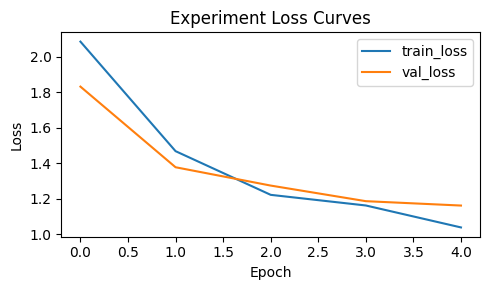

In [30]:
# Plot loss curves for the small experiment
if train_history and val_history:
    plt.figure(figsize=(5,3))
    plt.plot(train_history, label='train_loss')
    plt.plot(val_history, label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Experiment Loss Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [31]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    exact = 0
    total = 0
    cell_correct = 0
    cell_total = 0
    for batch in tqdm(loader, desc='Eval'):
        for k in ['enc','dec_in','tgt','enc_pad_mask','dec_pad_mask','row_idx','col_idx']:
            batch[k] = batch[k].to(device)
        logits = model(batch)
        preds = logits.argmax(-1)
        mask = batch['tgt'] != PAD
        equal = (preds == batch['tgt']) & mask
        cell_correct += equal.sum().item()
        cell_total += mask.sum().item()
        seq_equal = (equal.sum(dim=1) == mask.sum(dim=1))
        exact += seq_equal.sum().item()
        total += preds.size(0)
    return {
        'exact_match': exact / max(1, total),
        'cell_accuracy': cell_correct / max(1, cell_total)
    }
metrics = evaluate(model, val_loader)
print(metrics)

Eval: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

Eval: 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

{'exact_match': 0.0, 'cell_accuracy': 0.6699059561128526}


In [32]:
# === Qualitative Predictions (Validation Samples) ===
from random import sample as _sample
model.eval()
num_show = min(3, len(val_samples))
show_examples = _sample(val_samples, num_show) if num_show > 0 else []
print(f'Showing {len(show_examples)} validation examples:')
for ex in show_examples:
    grid_in = ex.input
    target = ex.output
    h_out, w_out = len(target), len(target[0]) if target else (0,0)
    enc_tokens = torch.tensor(encode_grid(grid_in), dtype=torch.long).unsqueeze(0).to(device)
    h_in, w_in = len(grid_in), len(grid_in[0]) if grid_in else (0,0)
    row_idx = torch.tensor([r for r in range(h_in) for _ in range(w_in)], dtype=torch.long).unsqueeze(0).to(device)
    col_idx = torch.tensor(list(range(w_in))*h_in, dtype=torch.long).unsqueeze(0).to(device)
    pad_mask = torch.zeros_like(enc_tokens, dtype=torch.bool)
    max_len = h_out * w_out + 2
    gen_seq = model.generate(enc_tokens, row_idx, col_idx, pad_mask, max_len=max_len)[0].cpu().tolist()
    pred_grid = decode_grid(gen_seq, h_out, w_out)
    print(f'Task {ex.task_id} subset {ex.subset} index {ex.index}')
    print('Input :', grid_in)
    print('Target:', target)
    print('Pred  :', pred_grid)
    print('-'*60)

Showing 3 validation examples:
Task 15663ba9 subset train index 2
Input : [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Target: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 1, 1, 1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 2, 1, 4, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 4, 1, 2, 0, 

In [33]:
@torch.no_grad()
def solve_batch(model, batch, max_len=256):
    for k in ['enc','enc_pad_mask','row_idx','col_idx']:
        batch[k] = batch[k].to(device)
    gen = model.generate(batch['enc'], batch['row_idx'], batch['col_idx'], batch['enc_pad_mask'], max_len=max_len)
    preds = gen.cpu().numpy().tolist()
    outputs = []
    for i, (h_in, w_in, h_out, w_out) in enumerate(batch['meta']):
        outputs.append(decode_grid(preds[i], h_out, w_out))
    return outputs

In [34]:
config = {
    'model': 'ArcTransformer', 'vocab_size': VOCAB_SIZE,
    'd_model': 256, 'nhead': 8, 'num_layers': 4, 'dim_ff': 512,
    'batch_size': BATCH_SIZE, 'epochs': EPOCHS, 'seed': SEED,
}
metrics = evaluate(model, val_loader)
with (RUN_DIR / 'metrics.json').open('w') as f:
    json.dump(metrics, f, indent=2)
torch.save({'model': model.state_dict(), 'config': config}, RUN_DIR / 'model.pt')
with (RUN_DIR / 'config.json').open('w') as f:
    json.dump(config, f, indent=2)
print('Saved to', RUN_DIR)

Eval: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Eval: 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Saved to c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414


In [35]:
_grid = [[1,2,3],[4,5,6]]
assert decode_grid(encode_grid(_grid), 2, 3) == _grid
print('Encode/Decode test passed')

# Paired augmentation sanity check on first few raw samples (no loader augment to avoid double aug)
for i in range(min(3, len(train_samples))):
    s = train_samples[i]
    aug_in, aug_out = apply_shared_aug(s.input, s.output)
    if aug_in and aug_out:
        print(f'[AUG SANITY] idx {i} in_shape={len(aug_in)}x{len(aug_in[0])} out_shape={len(aug_out)}x{len(aug_out[0])}')
        print('  in_row0:', aug_in[0][:10])
        print('  out_row0:', aug_out[0][:10])

batch = next(iter(train_loader))
for k in ['enc','dec_in','tgt','enc_pad_mask','dec_pad_mask','row_idx','col_idx']:
    batch[k] = batch[k].to(device)
with torch.no_grad():
    logits = model(batch)
assert logits.shape[:2] == batch['tgt'].shape
print('Forward pass shape test passed')

Encode/Decode test passed
Forward pass shape test passed
Forward pass shape test passed


In [36]:
from itertools import product
def sweep(grid):
    results = []
    for (lr, layers, heads, dropout) in product(grid['lr'], grid['layers'], grid['heads'], grid['dropout']):
        m = ArcTransformer(num_layers=layers, nhead=heads).to(device)
        opt = torch.optim.AdamW(m.parameters(), lr=lr)
        batch = next(iter(train_loader))
        for k in ['enc','dec_in','tgt','enc_pad_mask','dec_pad_mask','row_idx','col_idx']:
            batch[k] = batch[k].to(device)
        with torch.no_grad():
            logits = m(batch)
            B, L, V = logits.shape
            loss = criterion(logits.view(B*L, V), batch['tgt'].view(B*L)).item()
        results.append({'lr': lr, 'layers': layers, 'heads': heads, 'dropout': dropout, 'loss': loss})
    return sorted(results, key=lambda x: x['loss'])

In [37]:
try:
    example = next(iter(val_loader))
    for k in ['enc','dec_in','tgt','enc_pad_mask','dec_pad_mask','row_idx','col_idx']:
        example[k] = example[k].to(device)
    ts_path = RUN_DIR / 'model_ts.pt'
    scripted = torch.jit.trace(model, (example))
    scripted.save(str(ts_path))
    print('Saved TorchScript to', ts_path)
except Exception as e:
    print('TorchScript export skipped:', e)
try:
    import onnx
    onnx_path = RUN_DIR / 'model.onnx'
    print('ONNX export not implemented in this baseline')
except Exception as e:
    pass

TorchScript export skipped: Tracer cannot infer type of ({'enc': tensor([[ 8,  8,  8,  ..., 10, 10, 10],
        [ 8,  8,  8,  ...,  8,  8,  8],
        [ 0,  0,  0,  ..., 10, 10, 10],
        ...,
        [ 0,  0,  0,  ..., 10, 10, 10],
        [ 0,  0,  0,  ..., 10, 10, 10],
        [ 8,  0,  0,  ..., 10, 10, 10]]), 'dec_in': tensor([[11,  9,  9,  ..., 10, 10, 10],
        [11,  0,  0,  ..., 10, 10, 10],
        [11,  0,  0,  ..., 10, 10, 10],
        ...,
        [11,  0,  0,  ..., 10, 10, 10],
        [11,  0,  0,  ..., 10, 10, 10],
        [11,  8,  0,  ..., 10, 10, 10]]), 'tgt': tensor([[ 9,  9,  9,  ..., 10, 10, 10],
        [ 0,  0,  0,  ..., 10, 10, 10],
        [ 0,  0,  0,  ..., 10, 10, 10],
        ...,
        [ 0,  0,  0,  ..., 10, 10, 10],
        [ 0,  0,  3,  ..., 10, 10, 10],
        [ 8,  0,  0,  ..., 10, 10, 10]]), 'enc_pad_mask': tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [False, False

In [38]:
@torch.no_grad()
def evaluate_generate(model, loader, max_len_factor=1.2):
    model.eval()
    exact = 0
    total = 0
    cell_correct = 0
    cell_total = 0
    for batch in tqdm(loader, desc='Eval(gen)'):
        enc = batch['enc'].to(device)
        row_idx = batch['row_idx'].to(device)
        col_idx = batch['col_idx'].to(device)
        enc_pad_mask = batch['enc_pad_mask'].to(device)
        gen_max = [max(1, h_out*w_out) + 1 for (_, _, h_out, w_out) in batch['meta']]
        max_len = int(max(gen_max) * max_len_factor)
        gen = model.generate(enc, row_idx, col_idx, enc_pad_mask, max_len=max_len)
        preds = gen.cpu().tolist()
        tgt = batch['tgt']
        pad_mask = (tgt != PAD)
        for i in range(tgt.size(0)):
            tlen = pad_mask[i].sum().item()
            p = preds[i][:tlen]
            t = tgt[i, :tlen].tolist()
            cell_total += tlen
            cell_correct += sum(int(pi == ti) for pi, ti in zip(p, t))
            if p == t:
                exact += 1
            total += 1
    return {
        'exact_match_seq': exact / max(1, total),
        'cell_accuracy_seq': cell_correct / max(1, cell_total)
    }
gen_metrics = evaluate_generate(model, val_loader)
print(gen_metrics)

Eval(gen): 100%|██████████| 2/2 [00:53<00:00, 26.54s/it]

Eval(gen): 100%|██████████| 2/2 [00:53<00:00, 26.54s/it]

{'exact_match_seq': 0.0, 'cell_accuracy_seq': 0.503448275862069}


In [39]:
import inspect
from textwrap import indent

print("== ArcSeqDataset ==")
try:
    print(inspect.getsource(ArcSeqDataset))
except Exception as e:
    print("Error getting ArcSeqDataset source:", e)

print("\n== collate_fn or collate ==")
for name in list(globals().keys()):
    if name.lower().startswith("collate"):
        obj = globals()[name]
        if callable(obj):
            print(f"\n-- {name} --\n")
            try:
                print(inspect.getsource(obj))
            except Exception as e:
                print("(no source)", e)

print("\n== tokenization helpers (encode/decode) ==")
for name in [n for n in globals().keys() if any(n.lower().startswith(p) for p in ("encode","decode","grid_to","seq_to"))]:
    obj = globals()[name]
    if callable(obj):
        print(f"\n-- {name} --\n")
        try:
            print(inspect.getsource(obj))
        except Exception as e:
            print("(no source)", e)

print("\n== model.generate ==")
try:
    print(inspect.getsource(model.generate))
except Exception as e:
    print("Error getting model.generate source:", e)


== ArcSeqDataset ==
Error getting ArcSeqDataset source: source code not available

== collate_fn or collate ==

-- collate_batch --

def collate_batch(batch):
    B = len(batch)
    enc_lens = [len(b['enc']) for b in batch]
    dec_lens = [len(b['dec_in']) for b in batch]
    max_enc = max(enc_lens) if enc_lens else 0
    max_dec = max(dec_lens) if dec_lens else 0
    enc = torch.full((B, max_enc), PAD, dtype=torch.long)
    dec_in = torch.full((B, max_dec), PAD, dtype=torch.long)
    tgt = torch.full((B, max_dec), PAD, dtype=torch.long)
    enc_pad_mask = torch.ones((B, max_enc), dtype=torch.bool)
    dec_pad_mask = torch.ones((B, max_dec), dtype=torch.bool)
    row_idx = torch.zeros((B, max_enc), dtype=torch.long)
    col_idx = torch.zeros((B, max_enc), dtype=torch.long)
    meta = []
    for i, b in enumerate(batch):
        L_e = len(b['enc']); L_d = len(b['dec_in'])
        enc[i, :L_e] = b['enc']
        dec_in[i, :L_d] = b['dec_in']
        tgt[i, :len(b['tgt'])] = b['tgt']
    

In [40]:
def peek_sample(ds, idx=0):
    s = ds[idx]
    print("keys:", list(s.keys()))
    for k in ("enc","dec_in","tgt"):
        v = s.get(k)
        if isinstance(v, list):
            print(f"{k}: len={len(v)} head={v[:10]}")
        else:
            print(f"{k}: {type(v)} -> {v}")
    for k in ("h_in","w_in","h_out","w_out"):
        print(k, s.get(k))

print("Train sample 0:")
peek_sample(train_ds, 0)

print("\nVal sample 0:")
peek_sample(val_ds, 0)

print("\ntrain_loader.collate_fn:", getattr(train_loader, 'collate_fn', None))

Train sample 0:
keys: ['enc', 'dec_in', 'tgt', 'h_in', 'w_in', 'h_out', 'w_out']
enc: <class 'torch.Tensor'> -> tensor([7, 3, 9, 4])
dec_in: <class 'torch.Tensor'> -> tensor([11,  9,  7,  3,  4,  9,  7,  3,  4,  9,  7,  3,  4,  9,  7,  3,  4,  9,
         7,  3,  4,  9,  7,  3,  4,  9,  7,  3,  4,  9,  7,  3,  4,  9,  7,  3,
         4])
tgt: <class 'torch.Tensor'> -> tensor([ 9,  7,  3,  4,  9,  7,  3,  4,  9,  7,  3,  4,  9,  7,  3,  4,  9,  7,
         3,  4,  9,  7,  3,  4,  9,  7,  3,  4,  9,  7,  3,  4,  9,  7,  3,  4,
        12])
h_in 2
w_in 2
h_out 6
w_out 6

Val sample 0:
keys: ['enc', 'dec_in', 'tgt', 'h_in', 'w_in', 'h_out', 'w_out']
enc: <class 'torch.Tensor'> -> tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 1, 1, 1, 1,
        1, 8, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 8, 5, 1, 8, 2, 8, 1, 8, 1, 6, 6,
        6, 1, 8, 1, 7, 7, 7, 1, 8, 5, 1, 2, 2, 2, 1, 8, 1, 6, 6, 6, 1, 8, 1, 7,
        7, 7, 1, 8, 5, 1, 8, 2, 8, 1, 8, 1, 6, 6, 6, 1, 8, 1, 7, 7, 7, 1, 8

In [41]:
def has_eos(sample):
    return len(sample['tgt']) > 0 and sample['tgt'][-1] == EOS

# Inspect first 20 samples from train/val
train_checks = []
for i in range(min(20, len(train_ds))):
    s = train_ds[i]
    area = int(s['h_out']) * int(s['w_out'])
    train_checks.append({
        'i': i,
        'dec_in': len(s['dec_in']),
        'tgt': len(s['tgt']),
        'area': area,
        'has_eos': has_eos(s)
    })

val_checks = []
for i in range(min(20, len(val_ds))):
    s = val_ds[i]
    area = int(s['h_out']) * int(s['w_out'])
    val_checks.append({
        'i': i,
        'dec_in': len(s['dec_in']),
        'tgt': len(s['tgt']),
        'area': area,
        'has_eos': has_eos(s)
    })

print('Train len summaries:')
print({
    'avg_dec_in': sum(x['dec_in'] for x in train_checks)/len(train_checks),
    'avg_tgt': sum(x['tgt'] for x in train_checks)/len(train_checks),
    'avg_area': sum(x['area'] for x in train_checks)/len(train_checks),
    'eos_present_cnt': sum(1 for x in train_checks if x['has_eos'])
})
print('First 3:', train_checks[:3])

print('\nVal len summaries:')
print({
    'avg_dec_in': sum(x['dec_in'] for x in val_checks)/len(val_checks),
    'avg_tgt': sum(x['tgt'] for x in val_checks)/len(val_checks),
    'avg_area': sum(x['area'] for x in val_checks)/len(val_checks),
    'eos_present_cnt': sum(1 for x in val_checks if x['has_eos'])
})
print('First 3:', val_checks[:3])

Train len summaries:
{'avg_dec_in': 134.4, 'avg_tgt': 134.4, 'avg_area': 133.4, 'eos_present_cnt': 20}
First 3: [{'i': 0, 'dec_in': 37, 'tgt': 37, 'area': 36, 'has_eos': tensor(True)}, {'i': 1, 'dec_in': 37, 'tgt': 37, 'area': 36, 'has_eos': tensor(True)}, {'i': 2, 'dec_in': 82, 'tgt': 82, 'area': 81, 'has_eos': tensor(True)}]

Val len summaries:
{'avg_dec_in': 159.5, 'avg_tgt': 159.5, 'avg_area': 158.5, 'eos_present_cnt': 20}
First 3: [{'i': 0, 'dec_in': 86, 'tgt': 86, 'area': 85, 'has_eos': tensor(True)}, {'i': 1, 'dec_in': 163, 'tgt': 163, 'area': 162, 'has_eos': tensor(True)}, {'i': 2, 'dec_in': 181, 'tgt': 181, 'area': 180, 'has_eos': tensor(True)}]


In [46]:
import os

def load_best(model, path):
    if os.path.exists(path):
        sd = torch.load(path, map_location=device)
        if isinstance(sd, dict) and 'model' in sd:
            model.load_state_dict(sd['model'])
        else:
            model.load_state_dict(sd)
        print(f"Loaded best checkpoint: {path}")
    else:
        print(f"Best checkpoint not found: {path}")
load_best(model, str(best_path))

# NOTE: Model may have been trained before paired augmentation fix; consider retraining for cleaner learning signal.
@torch.no_grad()
def evaluate_generate(model, loader, max_gen_len=None, limit=None):
    model.eval()
    total_cells = 0
    correct_cells = 0
    exact_matches = 0
    total_examples = 0
    for bi, batch in enumerate(loader):
        enc = batch['enc'].to(device)
        enc_pad = batch['enc_pad_mask'].to(device)
        row_idx = batch['row_idx'].to(device)
        col_idx = batch['col_idx'].to(device)
        tgt = batch['tgt'].to(device)
        B = enc.size(0)
        metas = batch['meta']
        areas = [int(h_out) * int(w_out) for (_, _, h_out, w_out) in metas]
        max_area = max(areas) if areas else 0
        max_len = max_gen_len or (max_area + 2)
        ys = model.generate(enc, row_idx, col_idx, enc_pad, max_len=max_len)
        for i in range(B):
            area = areas[i]
            tgt_seq = tgt[i, :area]
            pred = ys[i]
            eos_pos = (pred == EOS).nonzero(as_tuple=False)
            if len(eos_pos) > 0:
                pred = pred[: int(eos_pos[0].item())]
            pred_area = pred[:area]
            if pred_area.numel() < area:
                pad = torch.full((area - pred_area.numel(),), PAD, dtype=pred_area.dtype, device=pred_area.device)
                pred_area = torch.cat([pred_area, pad], dim=0)
            else:
                pred_area = pred_area[:area]
            correct = (pred_area == tgt_seq).sum().item()
            correct_cells += correct
            total_cells += area
            if correct == area and pred.numel() >= area:
                exact_matches += 1
            total_examples += 1
        if limit and total_examples >= limit:
            break
    return {
        'exact_match': exact_matches / max(1, total_examples),
        'cell_accuracy': correct_cells / max(1, total_cells),
        'n_examples': total_examples,
    }
metrics_gen = evaluate_generate(model, val_loader, max_gen_len=MAX_H*MAX_W+2)
print("Generate eval (val):", metrics_gen)

Loaded best checkpoint: c:\Users\aibel\OneDrive\Documents\Code\arc-agi\models\run_20250824-113414\best.pt
Generate eval (val): {'exact_match': 0.0, 'cell_accuracy': 0.5066246056782334, 'n_examples': 20}
Generate eval (val): {'exact_match': 0.0, 'cell_accuracy': 0.5066246056782334, 'n_examples': 20}


Showing 5 validation samples


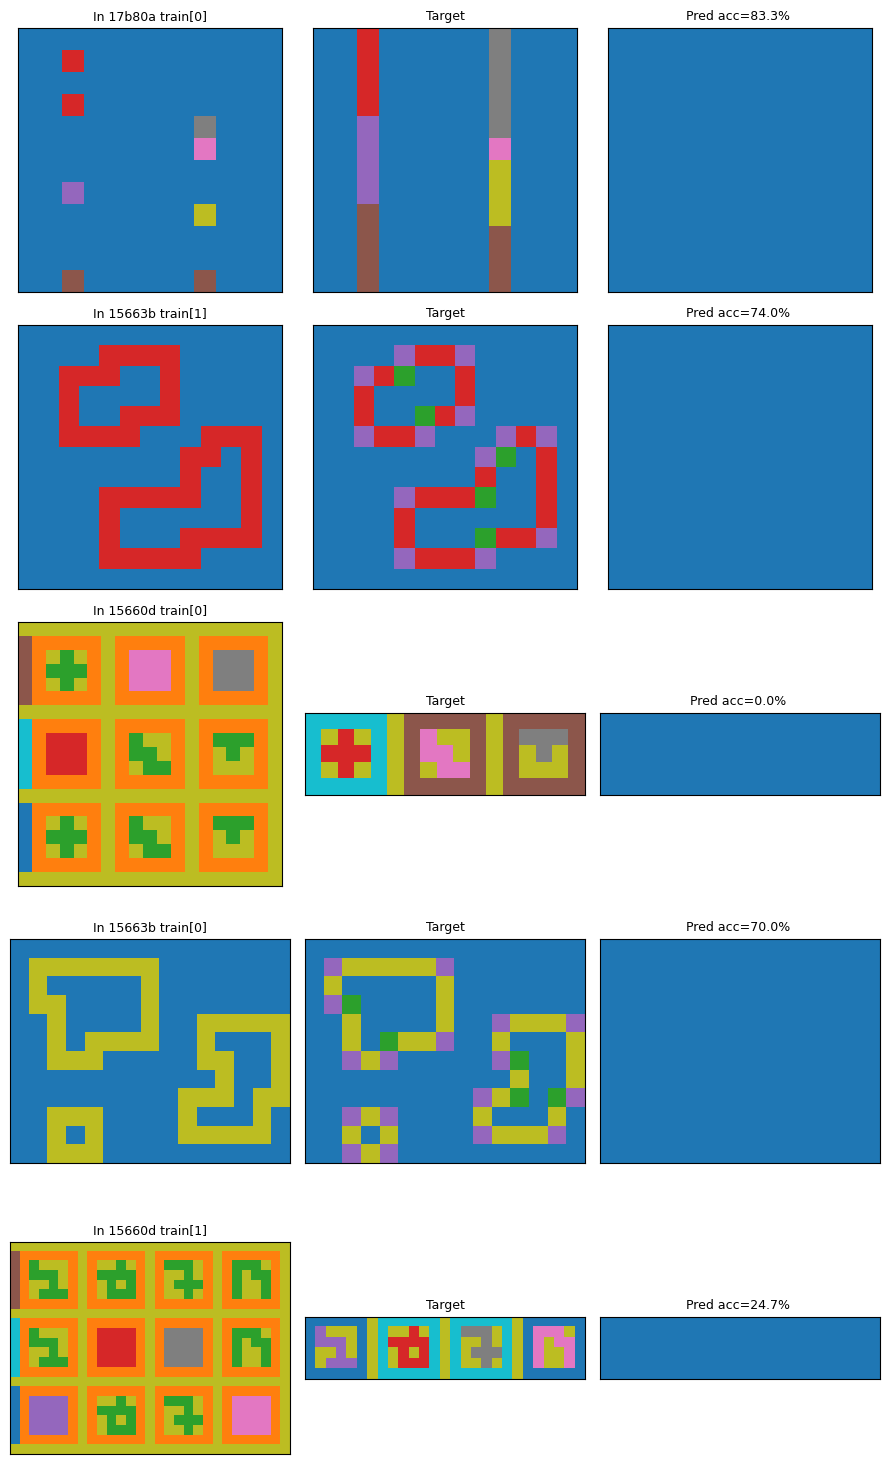

{'samples': 5, 'avg_cell_accuracy': 0.5039783767988897, 'exact_match_rate': 0.0}


In [47]:

import random, numpy as np, matplotlib.pyplot as plt, torch

if 'val_samples' not in globals():
    print('val_samples not defined; run earlier cells first.')
else:
    random.seed(1234)
    n_show = min(5, len(val_samples))
    picked = random.sample(val_samples, n_show) if n_show else []
    print(f"Showing {len(picked)} validation samples")

    def _predict_grid(grid_in, target_out):
        h_out = len(target_out)
        w_out = len(target_out[0]) if h_out else 0
        enc_tokens = torch.tensor(encode_grid(grid_in), dtype=torch.long).unsqueeze(0).to(device)
        h_in = len(grid_in); w_in = len(grid_in[0]) if h_in else 0
        row_idx = torch.tensor([r for r in range(h_in) for _ in range(w_in)], dtype=torch.long).unsqueeze(0).to(device)
        col_idx = torch.tensor(list(range(w_in))*h_in, dtype=torch.long).unsqueeze(0).to(device)
        pad_mask = torch.zeros_like(enc_tokens, dtype=torch.bool)
        max_len = h_out * w_out + 2
        with torch.no_grad():
            gen_seq = model.generate(enc_tokens, row_idx, col_idx, pad_mask, max_len=max_len)[0].cpu().tolist()
        pred_grid = decode_grid(gen_seq, h_out, w_out)
        return pred_grid

    def _grid_accuracy(pred, tgt):
        if not tgt: return 0.0, False
        flat_t = [c for row in tgt for c in row]
        flat_p = [c for row in pred for c in row][:len(flat_t)]
        correct = sum(int(a==b) for a,b in zip(flat_p, flat_t))
        return correct / max(1, len(flat_t)), (correct == len(flat_t))

    def _show_color_grid(ax, grid, title):
        arr = np.array(grid if grid else [[]], dtype=int)
        cmap = plt.get_cmap('tab10', 10)
        if arr.size == 0:
            ax.text(0.5,0.5,'(empty)', ha='center', va='center')
        else:
            ax.imshow(arr, cmap=cmap, vmin=0, vmax=9)
        ax.set_title(title, fontsize=9)
        ax.set_xticks([]); ax.set_yticks([])

    if n_show == 0:
        print('No validation samples available.')
    else:
        rows, cols = n_show, 3
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        if rows == 1:
            axes = np.array([axes])
        cell_accs, exact_flags = [], []
        for r, ex in enumerate(picked):
            inp = ex.input
            tgt = ex.output
            pred = _predict_grid(inp, tgt)
            acc, exact = _grid_accuracy(pred, tgt)
            cell_accs.append(acc); exact_flags.append(exact)
            _show_color_grid(axes[r,0], inp, f"In {ex.task_id[:6]} {ex.subset}[{ex.index}]")
            _show_color_grid(axes[r,1], tgt, 'Target')
            _show_color_grid(axes[r,2], pred, f"Pred acc={acc*100:.1f}% {'✓' if exact else ''}")
        plt.tight_layout(); plt.show()
        overall_cell_acc = sum(cell_accs)/len(cell_accs) if cell_accs else 0.0
        overall_exact = sum(exact_flags)/len(exact_flags) if exact_flags else 0.0
        print({'samples': len(picked), 'avg_cell_accuracy': overall_cell_acc, 'exact_match_rate': overall_exact})

In [ ]:
# === Color Imbalance & Majority Baseline Diagnostics === | cheating model 
from collections import Counter
import numpy as np, torch

def color_stats(samples):
    freq = Counter()
    total = 0
    for s in samples:
        for row in s.output:
            for c in row:
                freq[c] += 1
                total += 1
    top = freq.most_common()
    if not top:
        return {}
    return {
        'total_output_cells': total,
        'n_colors_present': len(freq),
        'top5': top[:5],
        'majority_color': top[0][0],
        'majority_frac': top[0][1] / total
    }

def majority_baseline_cell_accuracy(samples):
    stats = color_stats(samples)
    if not stats: return {}
    maj = stats['majority_color']
    correct = 0
    total = 0
    exact = 0
    for s in samples:
        tgt = s.output
        area = sum(len(r) for r in tgt)
        if area == 0: 
            continue
        # cell accuracy
        tgt_flat = [c for r in tgt for c in r]
        correct += sum(1 for c in tgt_flat if c == maj)
        total += area
        # exact match if all cells are maj
        if all(c == maj for c in tgt_flat):
            exact += 1
    return {
        'baseline_cell_acc': correct / total if total else 0.0,
        'baseline_exact_match': exact / len(samples) if samples else 0.0
    }

@torch.no_grad()
def model_cell_accuracy_on_val(model, val_loader):
    model.eval()
    cell_correct = 0
    cell_total = 0
    uniform_preds = 0
    total_examples = 0
    for batch in val_loader:
        for k in ['enc','dec_in','tgt','enc_pad_mask','dec_pad_mask','row_idx','col_idx']:
            batch[k] = batch[k].to(device)
        logits = model(batch)
        preds = logits.argmax(-1)
        mask = batch['tgt'] != PAD
        cell_correct += (preds[mask] == batch['tgt'][mask]).sum().item()
        cell_total += mask.sum().item()
        # uniform prediction check (ignoring PAD)
        for i in range(preds.size(0)):
            seq = preds[i][mask[i]]
            if seq.numel() > 0 and len(torch.unique(seq)) == 1:
                uniform_preds += 1
            total_examples += 1
    return {
        'model_cell_acc_val': cell_correct / cell_total if cell_total else 0.0,
        'uniform_prediction_rate': uniform_preds / total_examples if total_examples else 0.0
    }

train_color_stats = color_stats(train_samples)
maj_baseline = majority_baseline_cell_accuracy(train_samples)
model_val_perf = model_cell_accuracy_on_val(model, val_loader)

print('Color stats (train):', train_color_stats)
print('Majority baseline:', maj_baseline)
print('Model val perf:', model_val_perf)
print('If model_cell_acc_val <= baseline_cell_acc and uniform_prediction_rate high -> collapse confirmed.')

Color stats (train): {'total_output_cells': 28452, 'n_colors_present': 10, 'top5': [(0, 17166), (1, 1885), (2, 1782), (8, 1761), (4, 1648)], 'majority_color': 0, 'majority_frac': 0.6033319274567693}
Majority baseline: {'baseline_cell_acc': 0.6033319274567693, 'baseline_exact_match': 0.0}
Model val perf: {'model_cell_acc_val': 0.6699059561128526, 'uniform_prediction_rate': 0.1}
If model_cell_acc_val <= baseline_cell_acc and uniform_prediction_rate high -> collapse confirmed.
